# Data collection and cleaning
### This would be a visualisation notebook, where I can get my diagrams for FYP

In [50]:
#TODO check if y is only for the countplot

In [61]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import warnings

from datetime import datetime, timedelta
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from torch import flatten, nn
from torch.nn import Conv2d, Linear, LogSoftmax, MaxPool2d, Module, ReLU
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler

print("matplotlib version:", matplotlib.__version__)


matplotlib version: 3.4.3


In [ ]:
# warnings.filterwarnings("ignore")
# torch.set_num_threads(11)
# sns.set(rc={'figure.figsize':(16,5)})
# pd.set_option('display.max_columns', None)
# PATH = 'C:/Users/randa/Downloads/'

# Data Preparation 
## 1) reading in the data 
##### (insert explanation for the columns here)

In [ ]:
file = 'Test_Data.csv'

In [ ]:
#can change based on the data that is collected
data = pd.read_csv(file)
posts = ['POST'+str(i+1) for i in range(int(data.shape[1])-6)]
#First line is ommited for names
col_names = ['Asset', 'Time', 'Identifier'] + posts + ['X_Coord', 'Y_Coord']
data = pd.read_csv(file, header=0, names=col_names)
data.head(20)

,Asset,Time,Identifier,POST1,POST2,POST3,POST4,POST5,POST6,POST7,POST8,X_Coord,Y_Coord
0,cd:57,0,0,-76.25,-64.67,-79.5,-63.5,-74.0,-60.75,-66.00,-76.0,0,0
2,cd:57,0,2,-76.25,-64.67,-79.5,-63.5,-74.0,-60.75,-65.50,-76.0,0,0
4,cd:57,0,4,-76.25,-64.67,-79.5,-63.5,-74.0,-60.50,-66.00,-76.0,0,0
6,cd:57,0,6,-76.25,-64.67,-79.5,-63.5,-74.0,-60.50,-65.50,-76.0,0,0
64,cd:57,0,64,-76.25,-62.00,-79.5,-63.5,-74.0,-60.75,-66.00,-76.0,0,0
66,cd:57,0,66,-76.25,-62.00,-79.5,-63.5,-74.0,-60.75,-65.50,-76.0,0,0
68,cd:57,0,68,-76.25,-62.00,-79.5,-63.5,-74.0,-60.50,-66.00,-76.0,0,0
70,cd:57,0,70,-76.25,-62.00,-79.5,-63.5,-74.0,-60.50,-65.50,-76.0,0,0
128,cd:57,0,128,-77.00,-64.67,-79.5,-63.5,-74.0,-60.75,-66.00,-76.0,0,0
130,cd:57,0,130,-77.00,-64.67,-79.5,-63.5,-74.0,-60.75,-65.50,-76.0,0,0


In [ ]:
data.dtypes

Asset          object
Time            int64
Identifier      int64
POST1         float64
POST2         float64
POST3         float64
POST4         float64
POST5         float64
POST6         float64
POST7         float64
POST8         float64
X_Coord         int64
Y_Coord         int64
dtype: object

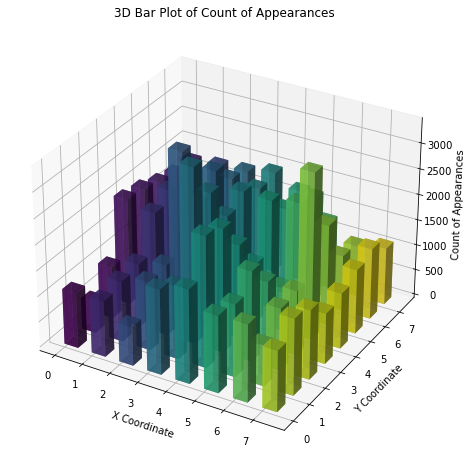

In [ ]:
# Count appearances of (X_Coord, Y_Coord) pairs
count_data = data.groupby(['X_Coord', 'Y_Coord']).size().reset_index(name='Count')

# Create a grid for the surface plot
x = count_data['X_Coord'].unique()
y = count_data['Y_Coord'].unique()
X, Y = np.meshgrid(x, y)

# Prepare the Z values (Count)
Z = np.zeros_like(X)

for i in range(len(count_data)):
    x_idx = np.where(x == count_data['X_Coord'].iloc[i])[0][0]
    y_idx = np.where(y == count_data['Y_Coord'].iloc[i])[0][0]
    Z[y_idx, x_idx] = count_data['Count'].iloc[i]


colors = plt.cm.viridis(np.linspace(0, 1, len(count_data)))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create 3D bar plot

x = count_data['X_Coord']
y = count_data['Y_Coord']
z = np.zeros(len(count_data))
dx = dy = 0.5  # Width and depth of bars
dz = count_data['Count']

ax.bar3d(x, y, z, dx, dy, dz, color=colors, alpha=0.7)

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Count of Appearances')
ax.set_title('3D Bar Plot of Count of Appearances')
plt.show()

In [ ]:
# calculate the weighted average for each post
#TODO the cdata, weighted avg etc

In [ ]:
grouped_data = data.sort_values(by=['Asset', 'Time']).reset_index(drop=True)

# Display the first 20 rows of the resulting DataFrame
grouped_data

,Asset,Time,Identifier,POST1,POST2,POST3,POST4,POST5,POST6,POST7,POST8,X_Coord,Y_Coord
0,31:ef,0,0,-71.0,-63.67,-78.5,-61.5,-77.0,-57.0,-61.0,-80.0,0,0
1,31:ef,0,64,-71.0,-64.00,-78.5,-61.5,-77.0,-57.0,-61.0,-80.0,0,0
2,31:ef,0,0,-67.0,-71.67,-64.0,-63.0,-70.5,-71.0,-80.0,-75.5,5,5
3,31:ef,0,64,-67.0,-71.00,-64.0,-63.0,-70.5,-71.0,-80.0,-75.5,5,5
4,31:ef,1,0,-71.0,-65.00,-78.5,-61.5,-77.5,-57.0,-63.0,-80.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107039,ed:11,2751,0,-71.0,-73.00,-71.0,-61.5,-77.0,-57.0,-61.0,-80.0,0,7
107040,ed:11,2751,64,-71.0,-72.00,-71.0,-61.5,-77.0,-57.0,-61.0,-80.0,0,7
107041,ed:11,2752,0,-71.0,-74.00,-71.5,-61.5,-77.0,-57.0,-61.0,-80.0,0,7
107042,ed:11,2753,0,-71.0,-75.00,-71.5,-61.5,-77.0,-57.0,-61.0,-80.0,0,7


In [ ]:
median = {}

# Iterate over each asset in the sorted DataFrame
for asset, group in grouped_data.groupby('Asset'):
    median[asset] = {}
    
    # Iterate over each unique timestamp within the asset
    for timestamp, sub_group in group.groupby('Time'):
        # Compute the median for the posts columns
        median_values = sub_group[posts].median()
        
        # Store the median values for each timestamp
        median[asset][timestamp] = median_values.to_dict()

In [ ]:
data['XY'] = 8 * data['X_Coord'] + data['Y_Coord']
X = data[['X_Coord', 'Y_Coord']].values  # Features
y = data['XY'].values                    

#TODO check if y is only for the countplot


# Print the results
print("\nTarget (y):")
print(y)


Target (y):
[ 0  0  0 ... 27 27 27]


# Neural Network code

In [ ]:
# data cleaning for relevant data and obtain validation set
cleaned = data.drop(['Asset', 'X_Coord', 'Y_Coord', 'Time', 'Identifier'], axis=1)

X, X_val, y, y_val = train_test_split(X, y, test_size=0.05, random_state=200)

X_val = X_val.astype(float)
X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

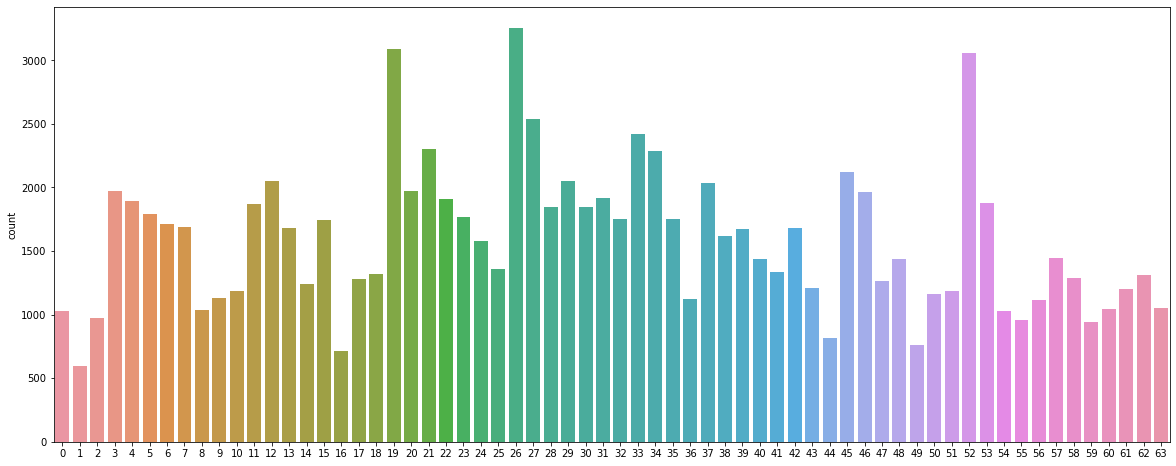

In [ ]:
plt.figure(figsize=(20,8))
sns.countplot(y)

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
kf.get_n_splits(X)

train_test_datasets = {'train': {'X': {},'y': {}}, 'test': {'X': {},'y': {}}}

for i, (train_index, test_index) in enumerate(kf.split(X,y), 1):
    train_test_datasets['train']['X'][str(i)] = X[train_index]
    train_test_datasets['test']['X'][str(i)] = X[test_index]
    train_test_datasets['train']['y'][str(i)] = y[train_index]
    train_test_datasets['test']['y'][str(i)] = y[test_index]

In [ ]:
X_train, X_test, y_train, y_test = train_test_datasets['train']['X']['1'], train_test_datasets['test']['X']['1'], train_test_datasets['train']['y']['1'], train_test_datasets['test']['y']['1']

X_train = X_train.astype(float)
X_test = X_test.astype(float)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Artificial Neural Network implementation

In [ ]:
# Base classs for all neural networks in pytorch
# Dropout that randomly sets 20% of the input units to zero during training to prevent overfitting

class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(in_features=64, out_features=192)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(in_features=192, out_features=256)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(in_features=256, out_features=192)
        self.output = nn.Linear(in_features=192, out_features=64)
 
    def forward(self, x):
        x = F.silu(self.fc1(x))
        x = self.dropout1(x)
        x = F.silu(self.fc2(x))
        x = self.dropout2(x)
        x = F.silu(self.fc3(x))
        x = self.dropout3(x)
        x = F.silu(self.fc4(x))
        x = self.output(x)
        return x
    
model = ANN()
# this is done with silu?

In [ ]:
EPOCHS = 1500
L_R = 5e-3

In [ ]:
criterion = nn.CrossEntropyLoss() # choose this if classification
optimizer = torch.optim.Adam(model.parameters(), lr=L_R, weight_decay=1e-5)

In [ ]:
loss_arr = []
loss_arr_test = []
last_loss = 100
patience = 8
trigger_times = 0
best_model = model
best_loss = 999

for i in range(0, EPOCHS+1):  
    y_pred = model.forward(X_train)
    
    loss_train = criterion(y_pred, y_train)
    loss_arr.append(loss_train.item())
    
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    with torch.no_grad():
        y_pred = model.forward(X_test)
    loss = criterion(y_pred, y_test)
    loss_arr_test += [float(loss)]
    if loss_arr_test[-1] < best_loss:
        best_loss = loss_arr_test[-1]
        best_model = model
 
    if i%100 == 0:
        print(f'Epoch: {i} Train Loss: {loss_train} Test Loss: {loss_arr_test[-1]}')
    
    if loss > last_loss:
        trigger_times += 1

        if trigger_times > patience:
            print('Early stop!')
            break
    else:
        trigger_times = 0

    last_loss = loss

RuntimeError: mat1 and mat2 shapes cannot be multiplied (81352x2 and 16x64)

In [ ]:
plt.title('Loss VS Epoch')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(loss_arr)
plt.plot(loss_arr_test)

: 

: 